### Pet breed classifier model using CNN ###

In [2]:
## Importing modules
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

import torch.nn as nn
import torch.optim as optim

import os
import random

##### Data pre-processing and handling #####

In [3]:
## Data pre-processing 

## Formatter.py is used intially to get dataset that is compatible with ImageFolder

## Defining paths
image_path = Path("Pet_breeds")
train_dir = image_path / "train"
test_dir = image_path / "test"

basic_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=train_dir, transform=basic_transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

mean = 0.0
std = 0.0
for images, _ in loader:
    mean += images.mean([0, 2, 3])
    std += images.std([0, 2, 3])
mean /= len(loader)
std /= len(loader)

print(f"Mean: {mean}, Std: {std}")

Mean: tensor([0.5519, 0.5181, 0.4543]), Std: tensor([0.2819, 0.2771, 0.2908])


In [117]:
## Image transform
transform_data = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())

])

transform_valid = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

## Dataset using ImageFolder
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=transform_data,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=transform_valid)

print(train_data.classes)
print(len(train_data),len(test_data))

from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=32, # how many samples per batch?
                              num_workers=min(os.cpu_count(), 4), # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True,
                              persistent_workers=True)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=32, 
                             num_workers=min(os.cpu_count(), 4), 
                             shuffle=False,
                             persistent_workers=True)

train_dataloader, test_dataloader


Using device: cuda
['abyssinian', 'american shorthair', 'beagle', 'boxer', 'bulldog', 'chihuahua', 'corgi', 'dachshund', 'german shepherd', 'golden retriever', 'husky', 'maine coon', 'mumbai cat', 'persian cat', 'pomeranian', 'pug', 'ragdoll cat', 'rottwiler', 'shiba inu', 'siamese cat', 'sphynx', 'yorkshire terrier']
2831 717


(<torch.utils.data.dataloader.DataLoader at 0x1f5827f1250>,
 <torch.utils.data.dataloader.DataLoader at 0x1f57f81fbc0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


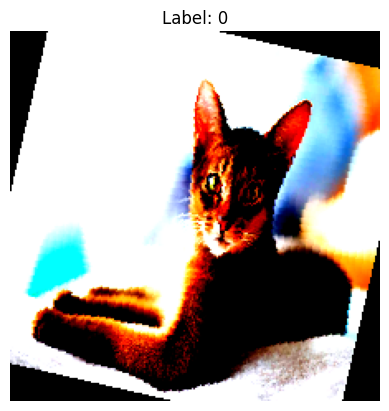

In [134]:
def show_image(tensor, title=None):
    # Transpose the tensor from (C, H, W) to (H, W, C) for display
    image = tensor.permute(1, 2, 0).numpy()
    
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

sample_image, sample_label = train_data[0]

show_image(sample_image, title=f'Label: {sample_label}')

##### CNN model architecture #####

In [135]:
class PetBreedModel(nn.Module):
    def __init__(self, input_shape:int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
            out_channels = 8,
            kernel_size = 3,
            stride = 1,
            padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(in_channels=8,
            out_channels = 16,
            kernel_size = 3,
            stride = 1,
            padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,256,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256*28*28, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256,23)
        )
     
    def forward(self,x:torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x



##### Training and testing Functions #####

In [137]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()

    train_loss, train_acc = 0,0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred,y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    return train_loss/len(dataloader), train_acc/len(dataloader)

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()

    test_loss, test_acc = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        test_loss += loss.item()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        test_acc += (y_pred_class == y).sum().item()/len(y_pred)
    
    return test_loss/len(dataloader), test_acc/len(dataloader)


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs):
    
    results = {"train_loss": [],
               "train_acc": [],
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
    
    return results

def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculations
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the class with the highest score
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    #class_report = classification_report(all_labels, all_preds, target_names=dataloader.dataset.classes)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    #print("\nClassification Report:\n", class_report)

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataloader.dataset.classes, yticklabels=dataloader.dataset.classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()




##### Running the model #####

In [138]:
model = PetBreedModel(input_shape=3,
                      output_shape=len(train_data.classes)).to(device)

## Loss function and Optimizer
loss_function = nn.CrossEntropyLoss()
Optimizer = torch.optim.Adam(params=model.parameters(),lr=0.0001,weight_decay=1e-4)

EPOCHS = 100

model_results = train(model = model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=Optimizer,
                      loss_fn=loss_function,
                      epochs=EPOCHS)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1233 | train_acc: 0.0422 | 
Epoch: 2 | train_loss: 3.0416 | train_acc: 0.0816 | 
Epoch: 3 | train_loss: 2.9773 | train_acc: 0.0931 | 
Epoch: 4 | train_loss: 2.9584 | train_acc: 0.0889 | 
Epoch: 5 | train_loss: 2.9051 | train_acc: 0.1152 | 
Epoch: 6 | train_loss: 2.8536 | train_acc: 0.1197 | 
Epoch: 7 | train_loss: 2.8000 | train_acc: 0.1346 | 
Epoch: 8 | train_loss: 2.7608 | train_acc: 0.1644 | 
Epoch: 9 | train_loss: 2.7235 | train_acc: 0.1693 | 
Epoch: 10 | train_loss: 2.7080 | train_acc: 0.1707 | 
Epoch: 11 | train_loss: 2.6763 | train_acc: 0.1848 | 
Epoch: 12 | train_loss: 2.6454 | train_acc: 0.2014 | 
Epoch: 13 | train_loss: 2.5850 | train_acc: 0.2152 | 
Epoch: 14 | train_loss: 2.5866 | train_acc: 0.1985 | 
Epoch: 15 | train_loss: 2.5516 | train_acc: 0.2178 | 
Epoch: 16 | train_loss: 2.5115 | train_acc: 0.2365 | 
Epoch: 17 | train_loss: 2.4984 | train_acc: 0.2304 | 
Epoch: 18 | train_loss: 2.4774 | train_acc: 0.2498 | 
Epoch: 19 | train_loss: 2.4336 | trai

Accuracy: 0.3821
Precision: 0.3699
Recall: 0.3821
F1 Score: 0.3679


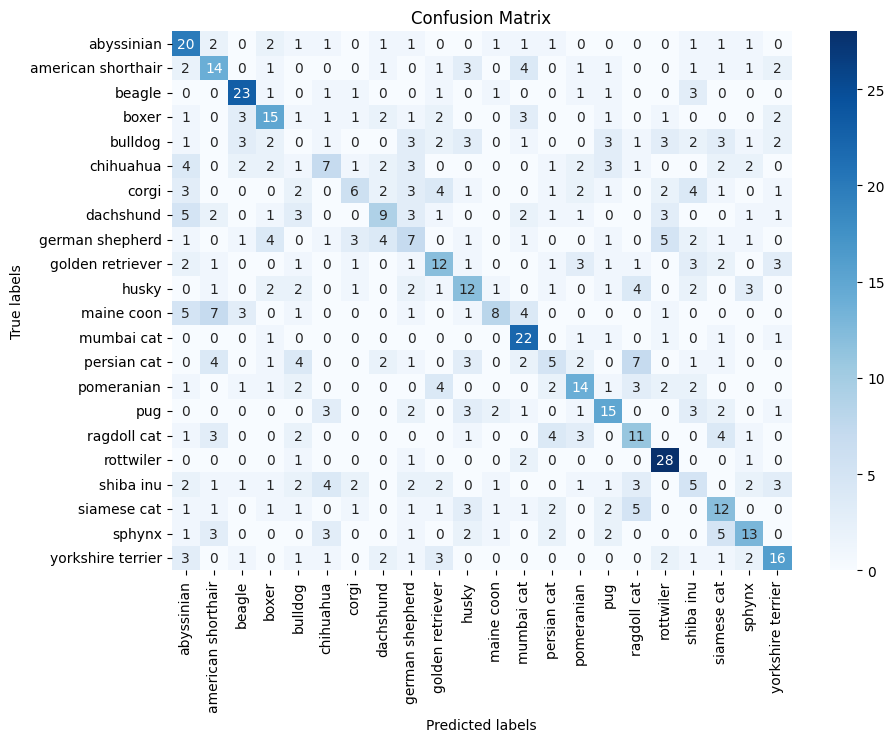

In [139]:
## Custom CNN Evaluation
evaluate_model(model,test_dataloader)


### Template function for finetuning Pretrained models ###

In [160]:
## Pre-trained model training function

def pretrained_finetune(model, dataloader, num_epochs):
    # Modify the model

    model.fc = nn.Linear(model.fc.in_features, 23)
    model = model.to(device)

    # Freeze all layers except the final fully connected layer
    for name, param in model.named_parameters():
        if "fc" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # First phase of training
    for epoch in range(num_epochs):
        model.train()
        stop = False
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Phase 1 - Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

    # Unfreeze all layers
    for name, param in model.named_parameters():
        param.requires_grad = True

    optimizer = optim.Adam(model.parameters(), lr=0.000001)

    # Second phase of training
    for epoch in range(num_epochs):
        model.train()
        stop = False
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if loss.item() < 0.05:
                stop = True
                break
            loss.backward()
            optimizer.step()
        print(f'Phase 2 - Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
        if stop:
            break

## ResNet Model (Pre-Trained) ##

In [163]:
resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
pretrained_finetune(resnet, train_dataloader, num_epochs=10)

Phase 1 - Epoch 1/10, Loss: 2.7198855876922607
Phase 1 - Epoch 2/10, Loss: 2.2980451583862305
Phase 1 - Epoch 3/10, Loss: 2.049161195755005
Phase 1 - Epoch 4/10, Loss: 1.8807026147842407
Phase 1 - Epoch 5/10, Loss: 1.5788015127182007
Phase 1 - Epoch 6/10, Loss: 1.5332623720169067
Phase 1 - Epoch 7/10, Loss: 1.3397655487060547
Phase 1 - Epoch 8/10, Loss: 1.0894949436187744
Phase 1 - Epoch 9/10, Loss: 0.9168609380722046
Phase 1 - Epoch 10/10, Loss: 1.127058506011963
Phase 2 - Epoch 1/10, Loss: 0.9785794615745544
Phase 2 - Epoch 2/10, Loss: 0.7717130780220032
Phase 2 - Epoch 3/10, Loss: 0.44382572174072266
Phase 2 - Epoch 4/10, Loss: 0.6076653003692627
Phase 2 - Epoch 5/10, Loss: 0.5327520370483398
Phase 2 - Epoch 6/10, Loss: 0.7151457071304321
Phase 2 - Epoch 7/10, Loss: 0.40446236729621887
Phase 2 - Epoch 8/10, Loss: 0.2823222875595093
Phase 2 - Epoch 9/10, Loss: 0.4341011047363281
Phase 2 - Epoch 10/10, Loss: 0.5891267657279968


Accuracy: 0.8870
Precision: 0.8905
Recall: 0.8870
F1 Score: 0.8866


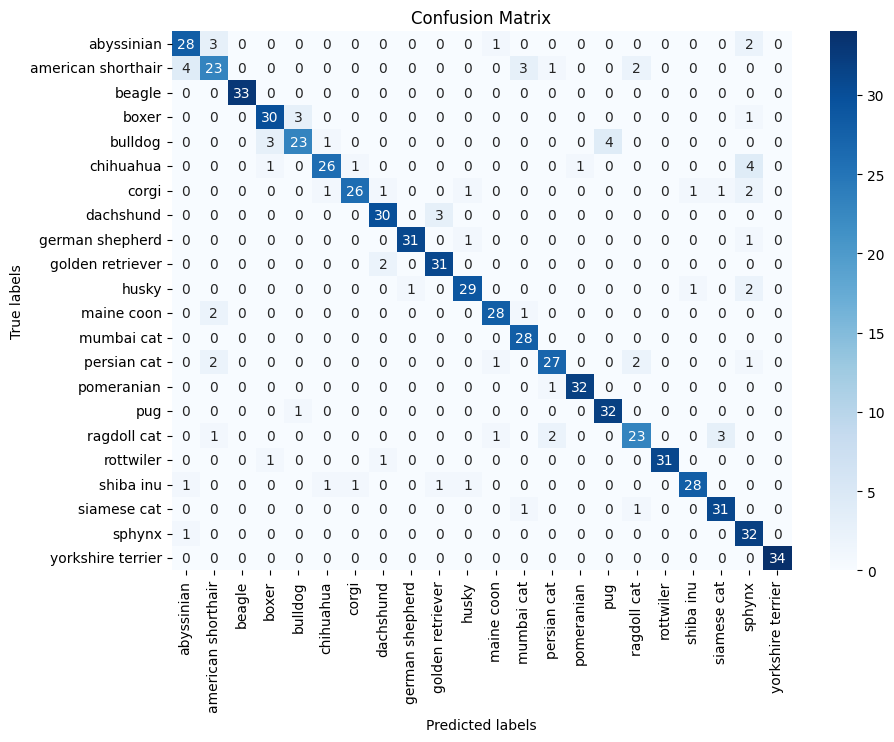

In [165]:
## Model Evaluation
evaluate_model(resnet,test_dataloader)